# Get Data

SK-Learn provides ways to download MNIST dataset, which is a popular handwritten digits dataset and rather pre-processed

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

/Users/andres/Desktop/Summer 23/machine-learning-techniques/my_env/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [20]:
import numpy as np
X, y = mnist["data"].values, mnist["target"].astype(np.uint8) # get np array from DF object via .values, and to numbers
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


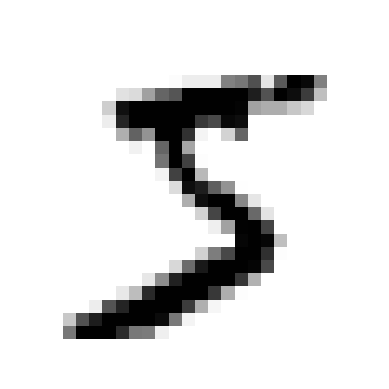

In [22]:
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

In [23]:
y[0]

5

# Test Set

In [24]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# [EXTRA] Implementing Cross-Validation

In [33]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

def my_cross_val(X_train, y_train):
    for train_idx, test_idx in skfolds.split(X_train, y_train):
        clone_clf = clone(sgd_clf)
        X_train_folds = X_train[train_idx]
        y_train_folds = y_train[train_idx]
        X_test_fold = X_train[test_idx]
        y_test_fold = y_train[test_idx]

        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_fold)
        n_correct = sum(y_pred == y_test_fold)
        print(n_correct / len(y_pred))

# [Extra] Confusion Matrix

In [34]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

my_cross_val(X_train, y_train_5)

0.9669
0.91625
0.96785


**Comparison with cross_val_score**

In [36]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

**Accuracy seems really high. Could there be some bias or skewed dataset?**
Likely so, since only about 10% of the images are 5, always outputting no will give an accuracy of about 90% already!

In [39]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [40]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Wiser to therefore use **precision** and **recall**

In [41]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [43]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

From ChatGPT: The SGDClassifier uses the stochastic gradient descent optimization algorithm to find the optimal parameters for a linear model. However, it is not limited to linear decision functions. By default, SGDClassifier assumes a linear decision function, but it can also learn non-linear decision boundaries by using non-linear transformations of the input features. This can be achieved by applying feature engineering techniques such as polynomial features or by using kernel methods. Additionally, SGDClassifier supports various loss functions, including those suitable for classification tasks such as logistic regression, hinge loss (for linear SVM), and modified Huber loss. So, while the underlying optimization algorithm is based on gradient descent, the decision function of SGDClassifier can be linear or non-linear depending on the choice of features and the selected loss function.

In [69]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function") 
# returns decision scores by specifying method param; 

In [70]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [80]:
def plot_precision_recall_vs_threshold_curve(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")

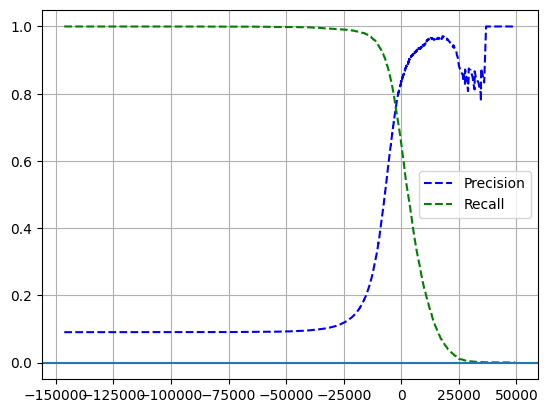

In [81]:
plot_precision_recall_vs_threshold_curve(precisions, recalls, thresholds)
plt.legend()
plt.grid()
plt.axhline()
plt.show()

**You can customize precision at the expense of recall (and vice-versa)**

In [86]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [87]:
from sklearn.metrics import precision_score, recall_score

y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


In [88]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [93]:
def roc_plot_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal 
    plt.grid(True)
    plt.xlabel('FPR')
    plt.ylabel('Recall')

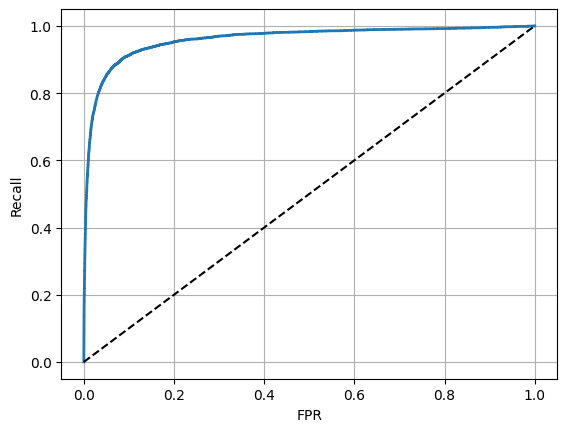

In [94]:
roc_plot_curve(fpr, tpr)

In [95]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**Using random forest classifier**

Does not have decision_function() method but has a predict_proba() method. Classifiers generally have one or the other.

In [100]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

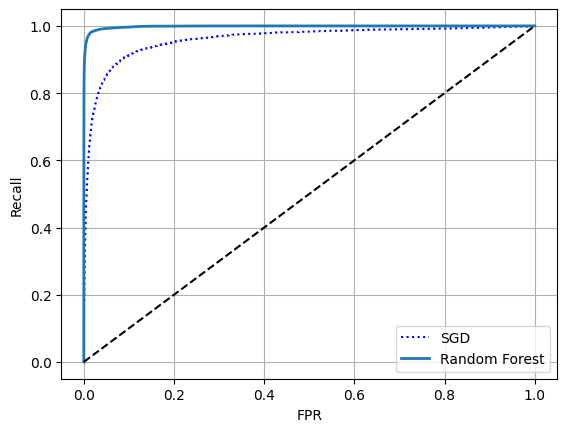

In [103]:
y_scores_forest = y_probas_forest[:, 1] # probs of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
roc_plot_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [104]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# Multiclass Classification

Binary classifiers distinguish between 2 classes. Multiclass classifiers can distinguish between more than 2 classes.

Some algorithms (eg SGD, RF, naive Bayes) can handle multiple classes natively. Others (logistic regression, SVM) are strictly binary classifiers.

Still, there are strategies to enable a strictly binary classifier to do multiclass classification. Two known methods are:
1. one-vs-one (OvO) where a binary classifier is trained for every pair of digits. you'll need 10C2 classifiers
2. one-vs-rest (OvR) where we train 10 binary classifier, one for each digit. Classifying an image requires obtaining decision score from each classifier and select the class whose classifier outputs the highest score

It seems the 2nd alternative requires much less training since fewer classifiers are required. However, the main advantage of OvO is that each classifier needs to be trained on the part of the training set for the two classes that it must distinguish!

Some algorithms scale poorly with size of training set so OvO strategy might be helpful since it reduces the size of the training set, and ultimately could be faster in training multiple classifiers on small training sets (e.g SVM classifiers). That said, most prefers OvR.

sklearn auto detects when we try to use a binary classifier for a multi-class classification task, and it runs OvO or OvR depending on the algorithm for that classifier.

In [105]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([X_test[1]])

array([2], dtype=uint8)

**Note**: SVC in sklearn  uses OvO strategy and some aggregation scheme to ultimately return 10 scores when decision_function is called

recall that the decision_score is a score that determines if an instance is a positive or negative class. Higher values lean towards positive class label

In [106]:
some_digit_scores = svm_clf.decision_function([X_test[1]])
some_digit_scores

array([[ 4.18553231,  4.18761078,  9.31442588,  8.29394839,  0.68969725,
         5.27476167,  7.28364539, -0.31459029,  5.28430293,  1.69121956]])

In [107]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [110]:
y_train_pred = cross_val_predict(SGDClassifier(random_state=42), X_train_scaled, y_train, cv=3)
y_train_pred

array([3, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [111]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

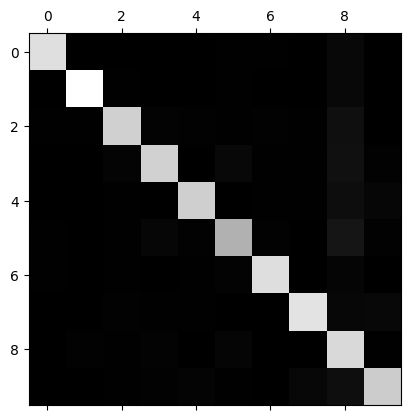

In [112]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

**Code to visually represent errors**

In [113]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

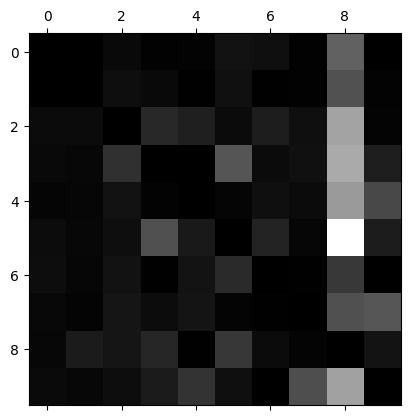

In [114]:
np.fill_diagonal(norm_conf_mx, 0) # ignore instances correctly classified
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [118]:
cl_a, cl_b = 5, 8
# actual - predict
aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

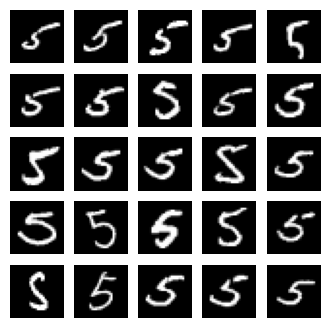

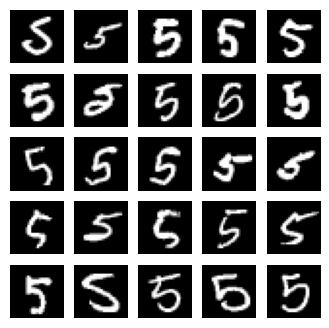

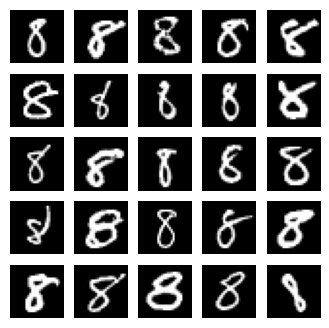

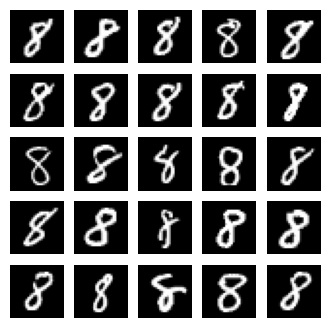

In [137]:
def plot_digits(digits, images_per_row=5):
    num_digits = digits.shape[0]
    num_rows = (num_digits - 1) // images_per_row + 1

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(4, 4))
    for i, ax in enumerate(axes.flatten()):
        if i < num_digits:
            ax.imshow(digits[i].reshape(28, 28), cmap='gray')
            ax.axis('off')
    

plot_digits(aa[:25], images_per_row=5)
plot_digits(ab[:25], images_per_row=5)
plot_digits(ba[:25], images_per_row=5)
plot_digits(bb[:25], images_per_row=5)
plt.show()

# Use of Multioutput Classification

**A system that removes noise from images**

In [171]:
# Artificially creating 'noisy' images from dataset

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise 
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train # this system is to take in a 'noisy' image and clean it by outputting the original
y_test_mod = X_test

In [172]:
def plot_digit(some_digit):
    some_digit.reshape(28, 28)
    plt.imshow(some_digit, cmap='binary')
    plt.axis("off")
    plt.show()

In [173]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
noisy_digit = X_test_mod[10]
clean_digit = knn_clf.predict([noisy_digit])

TypeError: Invalid shape (784,) for image data

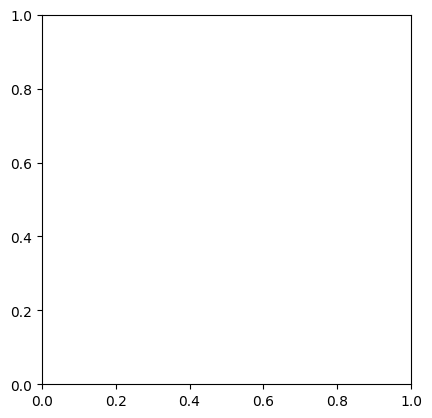

In [174]:
plot_digit(noisy_digit)

In [ ]:
plot_digit(clean_digit)